<center><img src='https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Jigsaw%20Multilingual%20Toxic%20Comment%20Classification/banner.png'></center>

<br>
<center><h1>Jigsaw Multilingual Toxic Comment Classification</h1></center>

<br>
<center><h3>Jigsaw Classification - DistilBERT with TPU and TF</h3></center>

<br>
<br>
It only takes one toxic comment to sour an online discussion. The Conversation AI team, a research initiative founded by [Jigsaw](https://jigsaw.google.com/) and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

## Dependencies

In [1]:
import os,gc , warnings, transformers
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tokenizers import BertWordPieceTokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [2]:
# Auxiliary functions
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(20, 18))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()
    
def plot_aur_curve(y_train, train_pred, y_valid, valid_pred):
    fpr_train, tpr_train, _ = roc_curve(y_train, train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, valid_pred)
    roc_auc_valid = auc(fpr_valid, tpr_valid)

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr_train, tpr_train, color='blue', label='Train AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_valid, tpr_valid, color='purple', label='ValidationAUC = %0.2f' % roc_auc_valid)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_confusion_matrix(y_train, train_pred, y_valid, valid_pred, labels=[0, 1]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    train_cnf_matrix = confusion_matrix(y_train, train_pred)
    validation_cnf_matrix = confusion_matrix(y_valid, valid_pred)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

## TPU configuration

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
train_toxic = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv", 
                          usecols=['id', 'comment_text', 'toxic'])
train_bias = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv", 
                         usecols=['id', 'comment_text', 'toxic'])
valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv', 
                    usecols=['id', 'comment_text', 'toxic'])
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv', 
                   usecols=['id', 'content'])

print('Jigsaw toxic comment samples %d' % len(train_toxic))
display(train_toxic.head())
print('Jigsaw unintended bias samples %d' % len(train_bias))
display(train_bias.head())

Jigsaw toxic comment samples 223549


,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


Jigsaw unintended bias samples 1902194


,id,comment_text,toxic
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000
1,59849,Thank you!! This would make my life a lot less...,0.000000
2,59852,This is such an urgent design problem; kudos t...,0.000000
3,59855,Is this something I'll be able to install on m...,0.000000
4,59856,haha you guys are a bunch of losers.,0.893617


# Model parameters

In [5]:
MAX_LEN = 512
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
EPOCHS = 12
LEARNING_RATE = 1e-5 # * strategy.num_replicas_in_sync
ES_PATIENCE = 3

base_model_name = 'distilbert-base-multilingual-cased'
model_path = 'model.h5'
vocab_path = '/kaggle/working'

## Tokenizer

In [6]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(base_model_name)
tokenizer.save_pretrained(vocab_path)

tokenizer = BertWordPieceTokenizer(vocab_path + '/vocab.txt', lowercase=False)
tokenizer.enable_truncation(max_length=MAX_LEN)
tokenizer.enable_padding(max_length=MAX_LEN)

## Build TF datasets

In [7]:
x_train = [x.ids for x in tokenizer.encode_batch(train_toxic['comment_text'].apply(lambda x : x).tolist())]
x_valid = [x.ids for x in tokenizer.encode_batch(valid['comment_text'].apply(lambda x : x).tolist())]
x_test = [x.ids for x in tokenizer.encode_batch(test['content'].apply(lambda x : x).tolist())]

y_train = train_toxic['toxic'].values
y_valid = valid['toxic'].values

In [8]:
AUTO = tf.data.experimental.AUTOTUNE

def get_training_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset():
    dataset = tf.data.Dataset.from_tensor_slices(x_test)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Learning rate schedule

Learning rate schedule: 1e-07 to 1e-05 to 1.09e-06


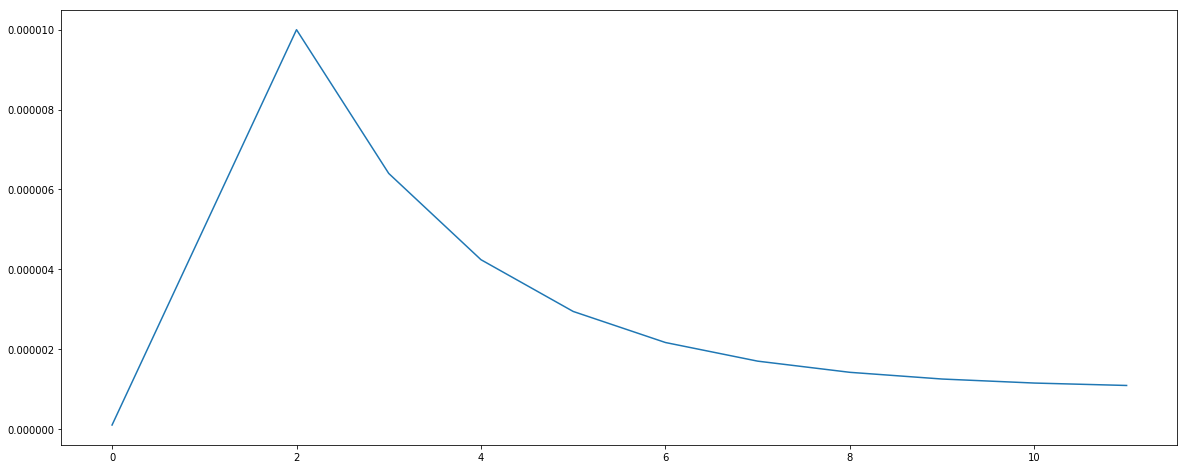

In [9]:
del train_bias
gc.collect()

LR_START = 1e-7
LR_MIN = 1e-6
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 2
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .6

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [10]:
def model_fn():
    base_model = transformers.TFDistilBertModel.from_pretrained(base_model_name)
    input_word_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
    sequence_output = base_model(input_word_ids)[0]
    
    x = GlobalAveragePooling1D()(sequence_output)
    x = Dropout(0.25)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)
    
    model = Model(inputs=input_word_ids, outputs=output)
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=['accuracy', metrics.AUC()])
    
    return model

with strategy.scope():
    model = model_fn()
    
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 512)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 512, 768),)       134734080 
_________________________________________________________________
global_average_pooling1d (Gl (None, 768)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________


# Train

In [11]:
STEPS_PER_EPOCH = len(x_train) // BATCH_SIZE

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)


history = model.fit(x=get_training_dataset(),
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=get_validation_dataset(),
                    callbacks=[es, lr_callback],
                    epochs=EPOCHS, 
                    verbose=1).history

Train for 436 steps, validate for 16 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-07.
Epoch 1/12
436/436 [==============================] - 315s 722ms/step - loss: 0.4177 - accuracy: 0.8390 - auc: 0.4859 - val_loss: 0.4414 - val_accuracy: 0.8460 - val_auc: 0.5200

Epoch 00002: LearningRateScheduler reducing learning rate to 5.05e-06.
Epoch 2/12
436/436 [==============================] - 255s 585ms/step - loss: 0.1888 - accuracy: 0.9295 - auc: 0.9083 - val_loss: 0.4023 - val_accuracy: 0.8514 - val_auc: 0.7914

Epoch 00003: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 3/12
436/436 [==============================] - 254s 582ms/step - loss: 0.1174 - accuracy: 0.9527 - auc: 0.9688 - val_loss: 0.5385 - val_accuracy: 0.8474 - val_auc: 0.7859

Epoch 00004: LearningRateScheduler reducing learning rate to 6.4e-06.
Epoch 4/12
436/436 [==============================] - 254s 581ms/step - loss: 0.1002 - accuracy: 0.9589 - auc: 0.9781 - val_loss: 0.5788 - val

## Model loss graph

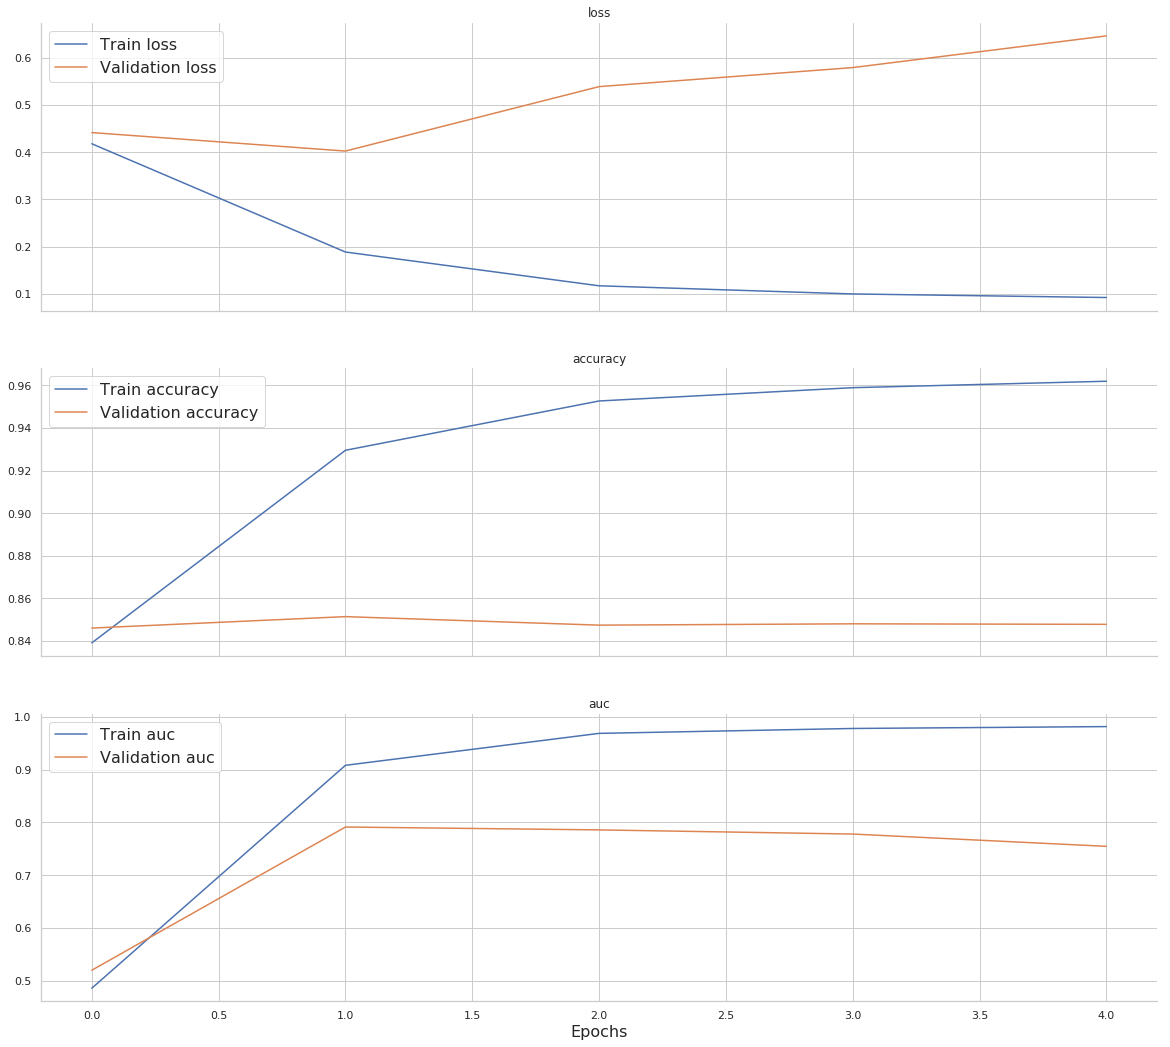

In [12]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'accuracy', 'auc'])

# Model evaluation

In [13]:
train_pred = model.predict(get_training_dataset(), steps=STEPS_PER_EPOCH)
valid_pred = model.predict(get_validation_dataset())
train_toxic = train_toxic[:len(train_pred)]
train_toxic['pred'] = train_pred
valid['pred'] = valid_pred

print('Train set ROC AUC %.4f' % roc_auc_score(train_toxic['toxic'], train_toxic['pred']))
print(classification_report(train_toxic['toxic'],  np.round(train_toxic['pred'])))
print('Validation set ROC AUC %.4f' % roc_auc_score(valid['toxic'], valid['pred']))
print(classification_report(valid['toxic'],  np.round(valid['pred'])))

Train set ROC AUC 0.4999
              precision    recall  f1-score   support

           0       0.90      0.91      0.91    201868
           1       0.10      0.09      0.09     21364

    accuracy                           0.83    223232
   macro avg       0.50      0.50      0.50    223232
weighted avg       0.83      0.83      0.83    223232

Validation set ROC AUC 0.7914
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      6770
           1       0.58      0.12      0.19      1230

    accuracy                           0.85      8000
   macro avg       0.72      0.55      0.56      8000
weighted avg       0.82      0.85      0.81      8000



# ROC Curve

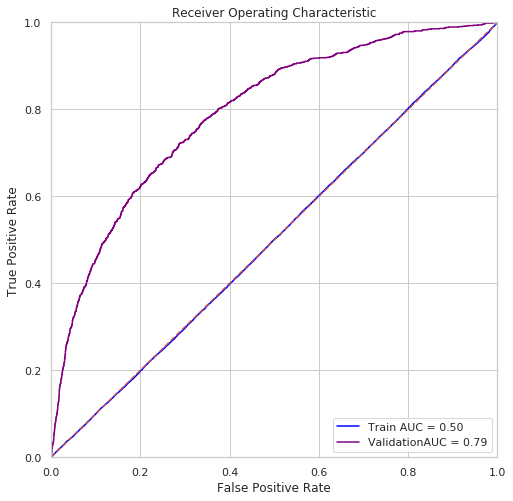

In [14]:
plot_aur_curve(train_toxic['toxic'], train_toxic['pred'], valid['toxic'], valid['pred'])

# Confusion matrix

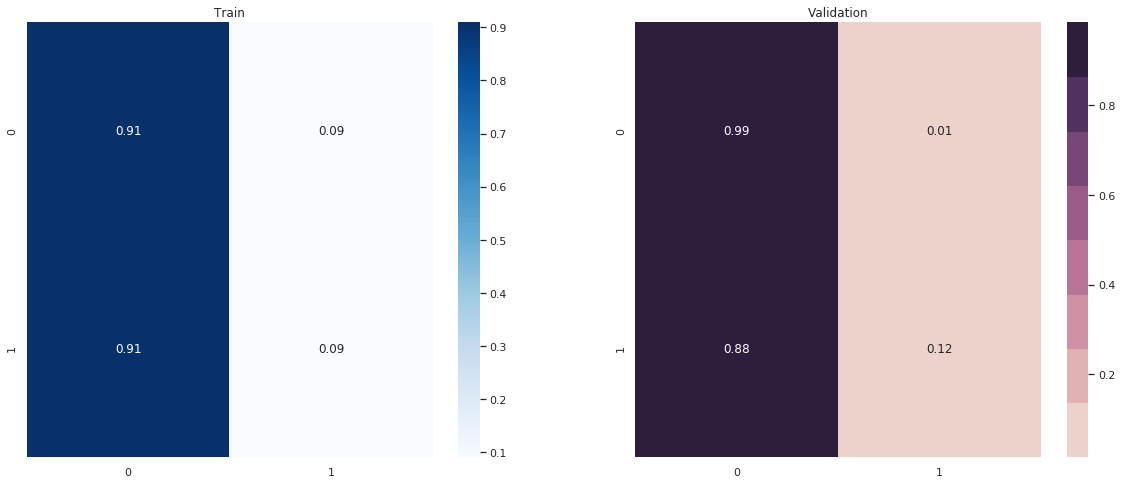

In [15]:
plot_confusion_matrix(train_toxic['toxic'], np.round(train_toxic['pred']), 
                      valid['toxic'], np.round(valid['pred']))

# Visualize predictions

In [16]:
print('Train set')
display(train_toxic[['comment_text', 'toxic', 'pred']].head(10))
print('Validation set')
display(valid[['comment_text', 'toxic', 'pred']].head(10))

Train set


,comment_text,toxic,pred
0,Explanation\nWhy the edits made under my usern...,0,0.003213
1,D'aww! He matches this background colour I'm s...,0,0.010190
2,"Hey man, I'm really not trying to edit war. It...",0,0.002544
3,"""\nMore\nI can't make any real suggestions on ...",0,0.980159
4,"You, sir, are my hero. Any chance you remember...",0,0.040088
5,"""\n\nCongratulations from me as well, use the ...",0,0.001273
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,0.213530
7,Your vandalism to the Matt Shirvington article...,0,0.001639
8,Sorry if the word 'nonsense' was offensive to ...,0,0.008310
9,alignment on this subject and which are contra...,0,0.008872


Validation set


,comment_text,toxic,pred
0,Este usuario ni siquiera llega al rango de ...,0,0.033107
1,Il testo di questa voce pare esser scopiazzato...,0,0.006050
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,1,0.021181
3,Bu maddenin alt başlığı olarak uluslararası i...,0,0.027794
4,Belçika nın şehirlerinin yanında ilçe ve belde...,0,0.014813
5,"güzel, zaten kaynaklandırması zor subjektif ka...",0,0.022054
6,"No es mala idea. De hecho, yo estaba pensando ...",0,0.006125
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık ç...",0,0.094206
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umar...,0,0.050965
9,Creo que es importante que podamos reconocer a...,0,0.014666


# Test set predictions

In [17]:
Y_test = model.predict(get_test_dataset())
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = Y_test
submission.to_csv('submission.csv', index=False)
submission.head(10)

,id,toxic
0,0,0.037518
1,1,0.002320
2,2,0.130434
3,3,0.043824
4,4,0.125432
5,5,0.050919
6,6,0.002082
7,7,0.306896
8,8,0.069682
9,9,0.669416
